In [1]:
%pip install numpy
%pip install Pillow
%pip install matplotlib
%pip install scikit-image
%pip install scipy

from PIL import Image
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from scipy.interpolate import interp1d, UnivariateSpline
import numpy as np
import json


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



Successfully extracted 100 points from 'sketch-adjusted.png'.


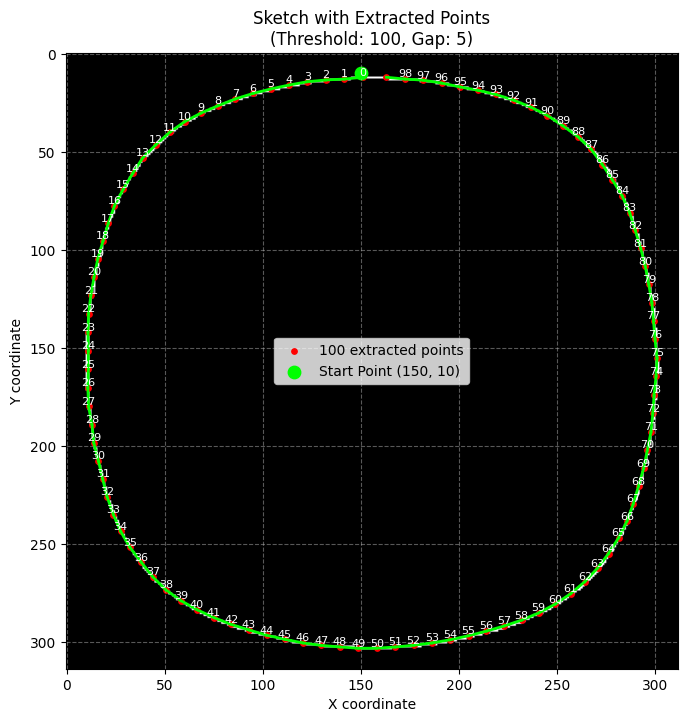

In [6]:
def sketch_to_points(img, threshold=128, gap=10, start_point=None, point_count=100):
    """
    Converts a sketch image (PIL Image or NumPy array) to a list of points.
    If img is a boolean NumPy array (skeletonized), 'threshold' is ignored.

    Args:
        img (PIL.Image or np.ndarray): Input image.
        threshold (int): Grayscale value for binarization if img is not boolean.
                         Ignored if img is a boolean array.
        gap (int): The minimum distance between selected points.
            Must be 1 or greater.

    Returns:
        list: A list of (x, y) tuples representing the points.
    """
    if not isinstance(gap, (int, float)) or gap <= 0:
        raise ValueError("Gap must be a positive number.")

    is_numpy_array = isinstance(img, np.ndarray)

    if is_numpy_array:
        height, width = img.shape
    else:
        width, height = img.size
    
    points = []

    for y_coord in range(0, height):
        for x_coord in range(0, width):
            if is_numpy_array:
                pixel_value = img[y_coord, x_coord]
                is_line_pixel = pixel_value 
            else:
                pixel_value = img.getpixel((x_coord, y_coord))
                is_line_pixel = pixel_value < threshold

            if is_line_pixel:
                closest_neighbor_dist = float('inf')
                if not points:
                    points.append((x_coord, y_coord))
                    continue

                for point_x, point_y in points:
                    dist = ((point_x - x_coord) ** 2 + (point_y - y_coord) ** 2) ** 0.5
                    if dist < closest_neighbor_dist:
                        closest_neighbor_dist = dist

                if closest_neighbor_dist > gap:
                    points.append((x_coord, y_coord))

    # Order points in nearest neighbor fashion
    if start_point:
        closest_points = sorted(points, key=lambda p: ((p[0] - start_point[0]) ** 2 + (p[1] - start_point[1]) ** 2))
        p = closest_points[0]
    else:
        p = points[0]
    new_points = [p]
    seen = set((p,))
    while len(new_points) < len(points):
        closest_neighbor_dist = float('inf')
        closest_neighbor = None
        for q in points:
            if p == q or q in seen:
                continue
            sq_dist = (p[0] - q[0]) ** 2 + (p[1] - q[1]) ** 2
            if sq_dist < closest_neighbor_dist:
                closest_neighbor_dist = sq_dist
                closest_neighbor = q
        new_points.append(closest_neighbor)
        seen.add(closest_neighbor)
        p = closest_neighbor

    points = np.array(new_points[::2])

    # Smooth the points using spline interpolation
    distance = np.cumsum(np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1)))
    distance = np.insert(distance, 0, 0) / distance[-1]
    alpha = np.linspace(0, 1, point_count)
    splines = [UnivariateSpline(distance, coords, k=3, s=.2) for coords in points.T]
    points = np.vstack([s(alpha) for s in splines]).T
    points = points.tolist()

    # Normalize points to a 0-1 range
    min_x, min_y, max_x, max_y = (
        min(x for x, _ in points), min(y for _, y in points),
        max(x for x, _ in points), max(y for _, y in points)
    )
    radix = 10_000
    width = max_x - min_x
    height = max_y - min_y
    scale = 1 / max(width, height)
    normalized_points = [
        (int((x - min_x) * scale * radix) / radix, int((y - min_y) * scale * radix) / radix)
        for x, y in points
    ]

    return points, normalized_points


def skeletonize_image(image_path, line_threshold_value):
    """
    Skeletonizes the image to extract lines. Lines are assumed to be darker than background.

    Args:
        image_path (str): Path to the PNG image file.
        line_threshold_value (int): Grayscale value below which a pixel is considered part of a line.

    Returns:
        np.ndarray: Boolean skeletonized image.
    """
    img_gray = Image.open(image_path).convert('L') # Convert to grayscale
    img_array_gray = np.array(img_gray)

    img_skeleton = skeletonize(img_array_gray < line_threshold_value)
    return img_skeleton


def canny_image(image_path, sigma=1.0):
    """
    Applies Canny edge detection to the image.

    Args:
        image_path (str): Path to the PNG image file.
        sigma (float): Standard deviation for Gaussian filter.

    Returns:
        np.ndarray: Boolean array representing edges.
    """
    from skimage import feature

    img_gray = Image.open(image_path).convert('L') # Convert to grayscale
    img_array_gray = np.array(img_gray)

    edges = feature.canny(img_array_gray, sigma=sigma)
    return edges


image_file_path = "sketch-adjusted.png"
darkness_level_threshold = 100
point_spacing_gap = 5
start_point = (150, 10)
point_count = 100

#image = skeletonize_image(image_file_path, darkness_level_threshold)
image = canny_image(image_file_path, sigma=1.0)
extracted_points, normalized_points = sketch_to_points(
    image,
    darkness_level_threshold,
    point_spacing_gap,
    start_point,
    point_count=point_count
)

# CSS: grayscale(0) brightness(0.55) contrast(7.5) brightness(10.5) contrast(9.5) sepia(8) brightness(100) grayscale(1)

if extracted_points:
    print(f"\nSuccessfully extracted {len(extracted_points)} points from '{image_file_path}'.")

    plt.figure(figsize=(10, 8))
    plt.imshow(image, cmap='gray')

    x_coordinates, y_coordinates = zip(*extracted_points)
    plt.scatter(x_coordinates, y_coordinates, color='red', s=15, label=f'{len(extracted_points)} extracted points')

    for i in range(len(extracted_points) - 1):
        ep1 = extracted_points[i]
        ep2 = extracted_points[i + 1]
        plt.plot([ep1[0], ep2[0]], [ep1[1], ep2[1]], color='lime', linewidth=2)
        plt.annotate(str(i), (ep1[0], ep1[1]), color='white', fontsize=8, ha='center', va='bottom')

    if start_point:
        plt.scatter([start_point[0]], [start_point[1]], color='lime', s=80, label=f'Start Point {start_point}')

    plt.title(f"Sketch with Extracted Points\n(Threshold: {darkness_level_threshold}, Gap: {point_spacing_gap})")
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    with open("extracted_points.json", "w") as f:
        json.dump(normalized_points, f, indent=2)
